# 1-Importing Libraries

In [155]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

# 2 - ETL(Extracting,Tranforming,Loading) Pipeline with MYSQL server to extract data

In [319]:
user = "root"
password = "Us01012003"
host= "127.0.0.1"
port = "3306"
database = "Project1"

engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:{port}/{database}")
query = "select * from ab_test_cleaned"

df = pd.read_sql(query,engine)
df.shape

(196041, 8)

# 3 -Understanding Dataset

In [322]:
df.shape

(196041, 8)

In [324]:
df.columns

Index(['user_id', 'click', 'groups_exp', 'session_time', 'click_time',
       'device_type', 'referral_source', 'z_score'],
      dtype='object')

In [326]:
df.dtypes

user_id              int64
click                int64
groups_exp          object
session_time       float64
click_time          object
device_type         object
referral_source     object
z_score            float64
dtype: object

In [328]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196041 entries, 0 to 196040
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   user_id          196041 non-null  int64  
 1   click            196041 non-null  int64  
 2   groups_exp       196041 non-null  object 
 3   session_time     196041 non-null  float64
 4   click_time       196041 non-null  object 
 5   device_type      196041 non-null  object 
 6   referral_source  196041 non-null  object 
 7   z_score          196041 non-null  float64
dtypes: float64(2), int64(2), object(4)
memory usage: 12.0+ MB


In [330]:
df.nunique()

user_id             10000
click                   2
groups_exp              2
session_time       196023
click_time          20158
device_type             4
referral_source         5
z_score            196023
dtype: int64

In [332]:
df.describe()

,user_id,click,session_time,z_score
count,196041.000000,196041.000000,196041.000000,196041.000000
mean,5002.634077,0.349131,4.992257,0.109312
std,2892.014047,0.476697,4.970171,0.044383
min,1.000000,0.000000,0.000007,0.000001
25%,2488.000000,0.000000,1.443805,0.080771
50%,5011.000000,0.000000,3.466524,0.120650
75%,7513.000000,1.000000,6.937201,0.145210
max,10000.000000,1.000000,80.778581,0.846715


# 3 -Transforming/Cleaning Data

# 1 - Transforming Data

In [336]:
df["click_time"] = pd.to_datetime(df["click_time"]) 

In [338]:
df.drop(["user_id","z_score"],axis=1,inplace=True)
df

,click,groups_exp,session_time,click_time,device_type,referral_source
0,0,exp,1.639570,2024-01-14 22:15:00,mobile,email
1,0,exp,2.377526,2024-01-07 19:20:00,mobile,social
2,0,exp,0.914652,2024-01-09 15:13:00,desktop,social
3,0,exp,2.961715,2024-01-01 15:36:00,mobile,direct
4,0,exp,7.032543,2024-01-08 00:46:00,desktop,search
...,...,...,...,...,...,...
196036,1,con,5.500404,2024-01-03 19:16:00,mobile,ads
196037,0,con,2.085356,2024-01-08 19:49:00,mobile,search
196038,0,con,3.535225,2024-01-11 17:26:00,mobile,social
196039,1,exp,2.849497,2024-01-11 18:36:00,mobile,direct


In [340]:
df['device_type'] =df['device_type'].replace('MOBILE','mobile')
df['device_type'] =df['device_type'].replace('Desktop','desktop')

# 2 - Checking for Null Values

In [343]:
df.isnull().sum()

click              0
groups_exp         0
session_time       0
click_time         0
device_type        0
referral_source    0
dtype: int64

# 3 - Checking for duplicated Values

In [345]:
df.duplicated().sum()

18

In [317]:
df.drop_duplicates(inplace=True)

# 4 - Checking for Outliers 

<Axes: title={'center': 'Distribution of session_time before Outliers removal'}, ylabel='session_time'>

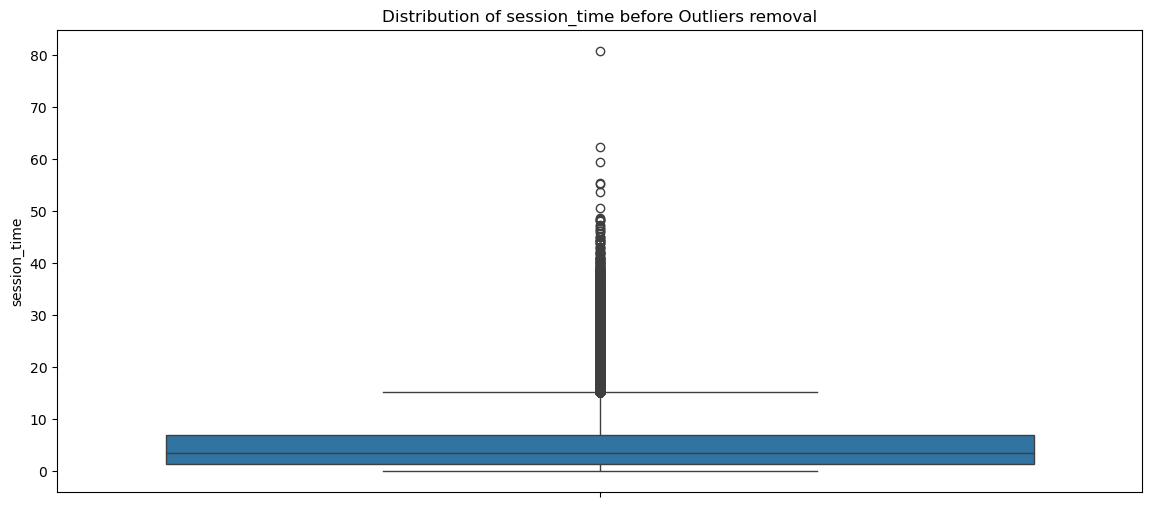

In [347]:
plt.figure(figsize=(14,6))
plt.title("Distribution of session_time before Outliers removal")
sns.boxplot(df["session_time"])

<Axes: title={'center': 'Distribution of session_time'}, xlabel='session_time', ylabel='Count'>

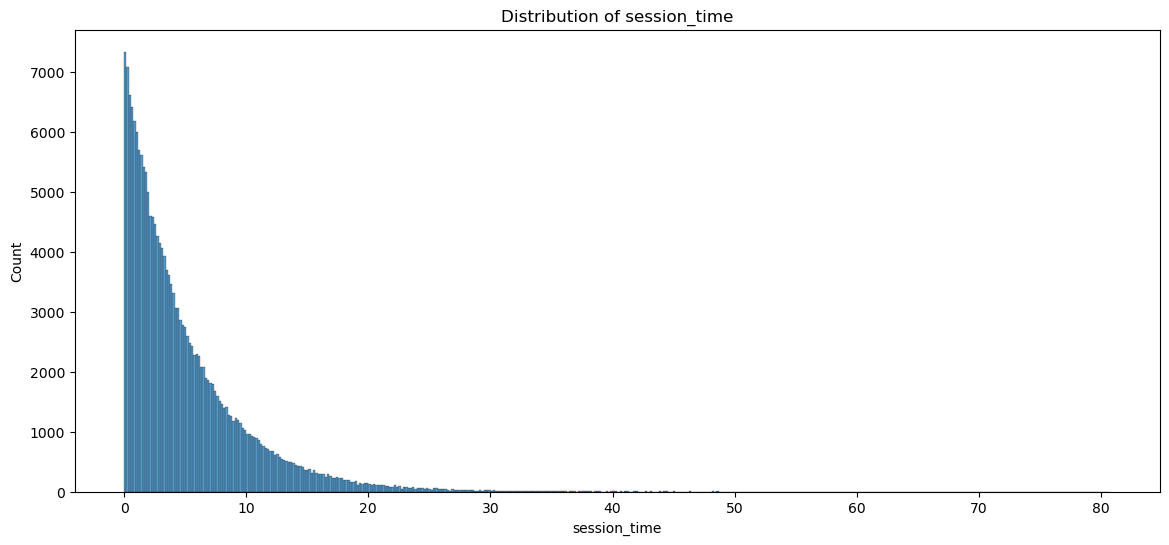

In [349]:
plt.figure(figsize=(14,6))
plt.title("Distribution of session_time")
sns.histplot(df["session_time"])    # The distibution is Skewed Right

# 5 - Removing Outliers 

In [352]:
q1=df["session_time"].quantile(0.25)
q3 = df["session_time"].quantile(0.75)
iqr = q3-q1
lower = q1-1.5*(iqr)
upper = q3+1.5*(iqr)
print(lower,upper)

-6.7962890171400865 15.177295269768873


In [354]:
# Capping the Outliers
df["session_time"] =np.where(df["session_time"]>upper,upper,df["session_time"])

<Axes: title={'center': 'Distribution of session_time after removing outliers '}, ylabel='session_time'>

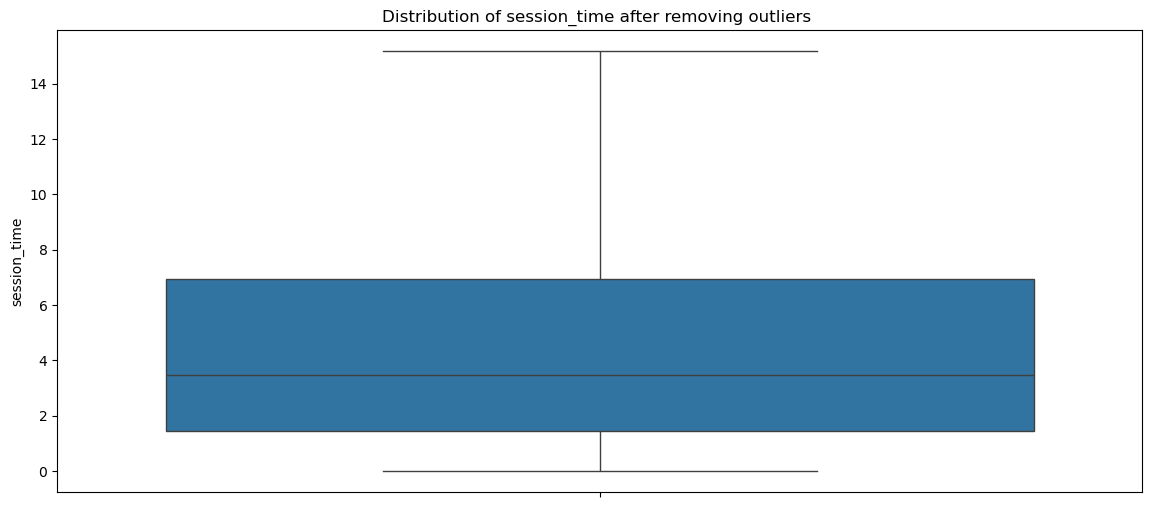

In [356]:
plt.figure(figsize=(14,6))
plt.title("Distribution of session_time after removing outliers ")
sns.boxplot(df["session_time"])

# 6- Explanatory Data Analysis(EDA)

# (A) - What is the Proportion of Controlled/Experimental group,Clicks,Device type used, and Referral source used

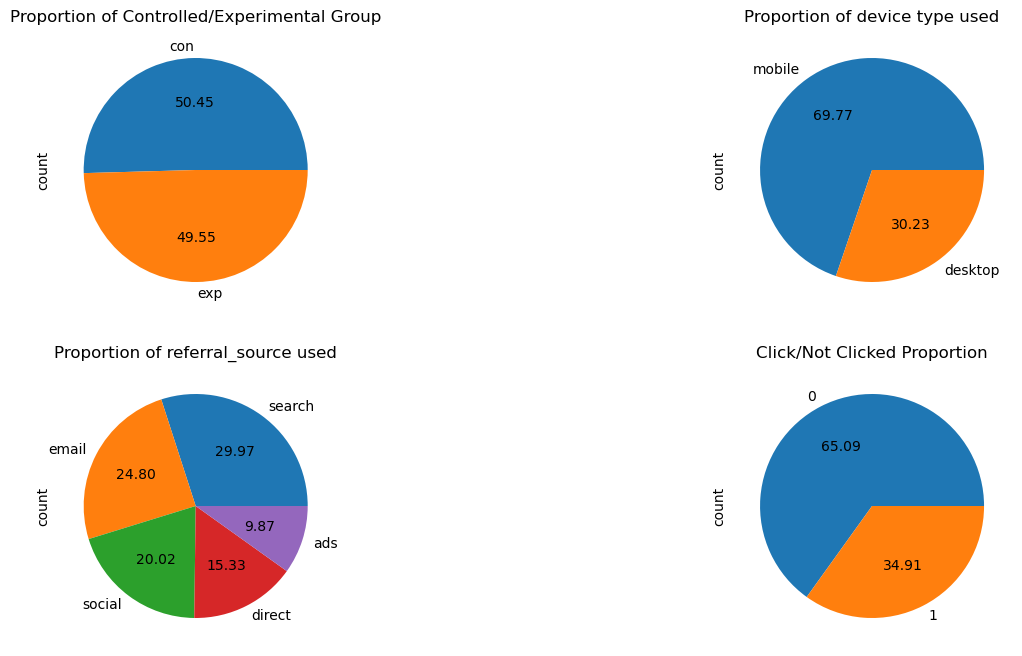

In [360]:
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
plt.title("Proportion of Controlled/Experimental Group")
df["groups_exp"].value_counts().plot(kind="pie",autopct="%0.2f")


plt.subplot(2,2,2)
plt.title("Proportion of device type used")
df["device_type"].value_counts().plot(kind="pie",autopct="%0.2f")

plt.subplot(2,2,3)
plt.title("Proportion of referral_source used")
df["referral_source"].value_counts().plot(kind="pie",autopct="%0.2f")


plt.subplot(2,2,4)
plt.title("Click/Not Clicked Proportion")
df["click"].value_counts().plot(kind="pie",autopct="%0.2f")

plt.show()

# Insights:
1) Balanced A/B Test Groups:The dataset shows an almost equal distribution between the Control and Experimental groups (~50% each), ensuring fairness and reliability in A/B testing comparisons.

2) Device Usage PreferenceMobile users make up nearly twice the number of Desktop users. This indicates that the majority of users prefer accessing the web application via mobile devices, suggesting the interface is mobile-optimized and user-friendly on smaller screens.

3) Traffic Source Distribution:Most users arrive through Search and Email, while Ads contribute to only ~9% of the traffic. This suggests that either ad campaigns are not performing well or the targeting needs optimization. The company should consider reallocating marketing budgets toward more effective channels or refining the ad strategy for better ROI.

4) Low Click-Through Rate (CTR):Approximately 65% of visitors did not click, with only 34.91% interacting with the web service. This low engagement rate highlights the need for improvement in the user experience or content. The Experimental group was likely introduced to test enhancements aimed at increasing CTR.

# (B) Segment performance by device and referral source(Clustering)

# (1) -Creating Segment using K-Means Clustering

In [365]:
x = df[["device_type","referral_source"]]
X = pd.get_dummies(x,dtype=int)
scaler =StandardScaler().fit_transform(X)
cluster = KMeans(n_clusters=3,random_state=42)
df["Segment"] = cluster.fit_predict(scaler)

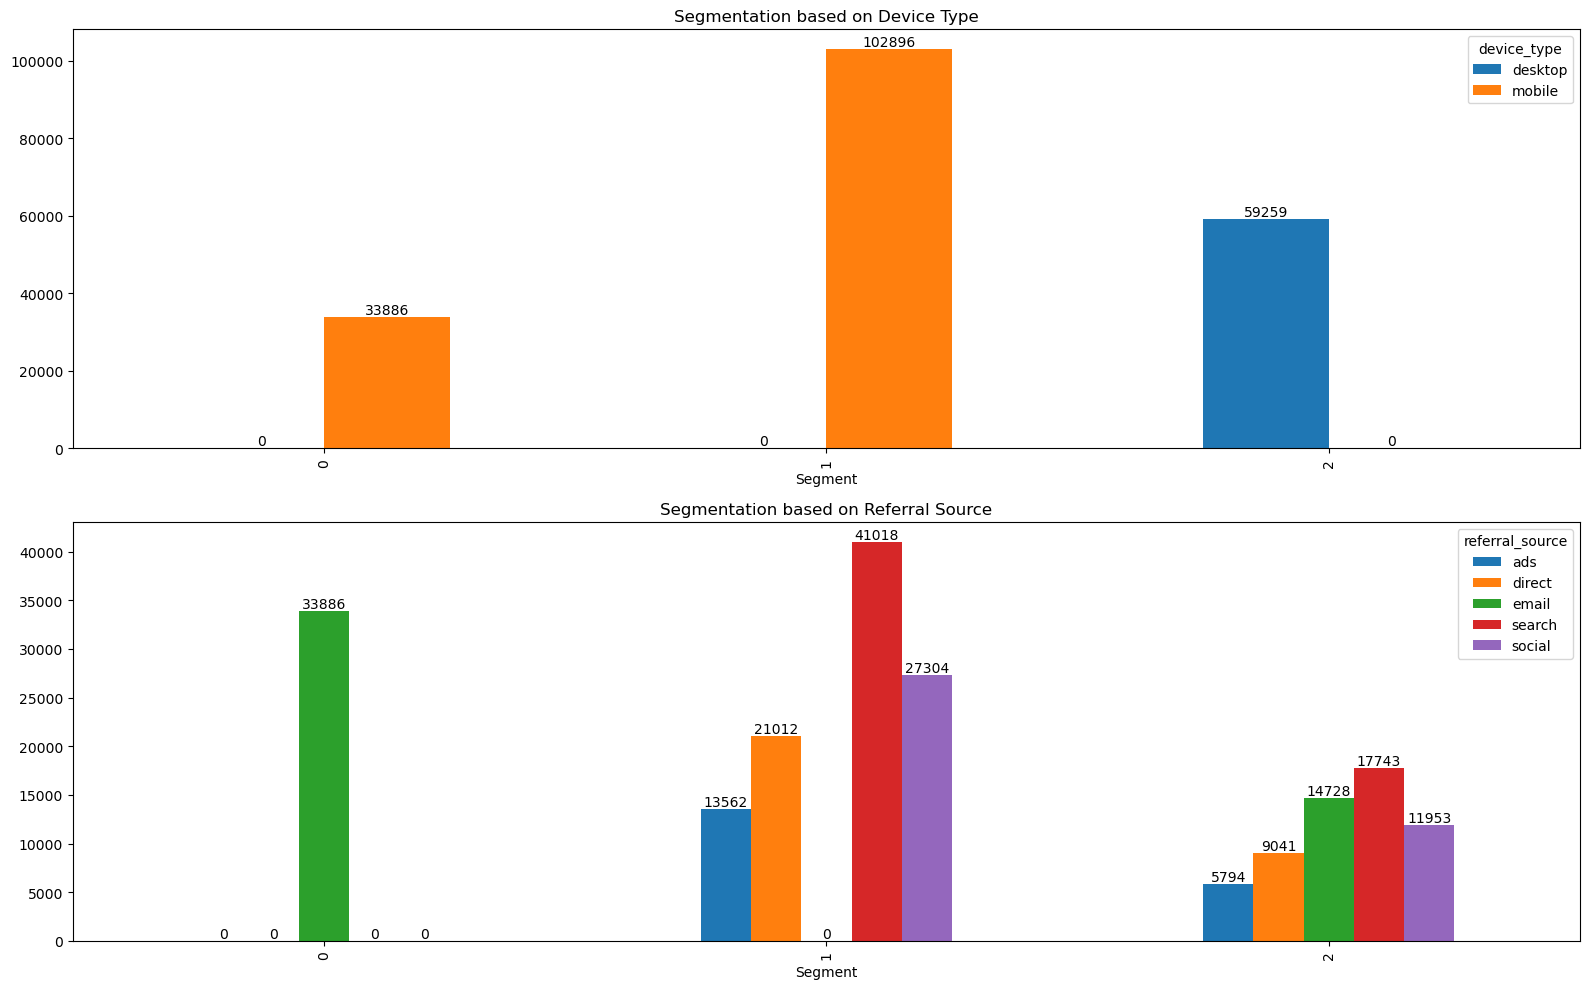

In [367]:
fig, axes = plt.subplots(2, 1, figsize=(16, 10))  # 2 rows, 1 column

# --- First subplot: Segment vs Device Type ---
data = pd.crosstab(df["Segment"], df["device_type"])
ax = data.plot(kind="bar", ax=axes[0])
axes[0].set_title("Segmentation based on Device Type")
for container in ax.containers:
    ax.bar_label(container)

# --- Second subplot: Segment vs Referral Source ---
data1 = pd.crosstab(df["Segment"], df["referral_source"])
ax1 = data1.plot(kind="bar", ax=axes[1])
axes[1].set_title("Segmentation based on Referral Source")
for container in ax1.containers:
    ax1.bar_label(container)

plt.tight_layout()
plt.show()


# Insights-:
1) Segment 1 contains only people who came from email search and viewing web application using mobile.
2) Segemnt 2 containes people who came from other referall_source instead of email and viewing application using Mobile
3) Segemnt 3 containes people who came using all other referral_source and viewing application using desktop

# 2- Analysing Performance based on Segemnet(CTR,session_time,Bounce Rate)

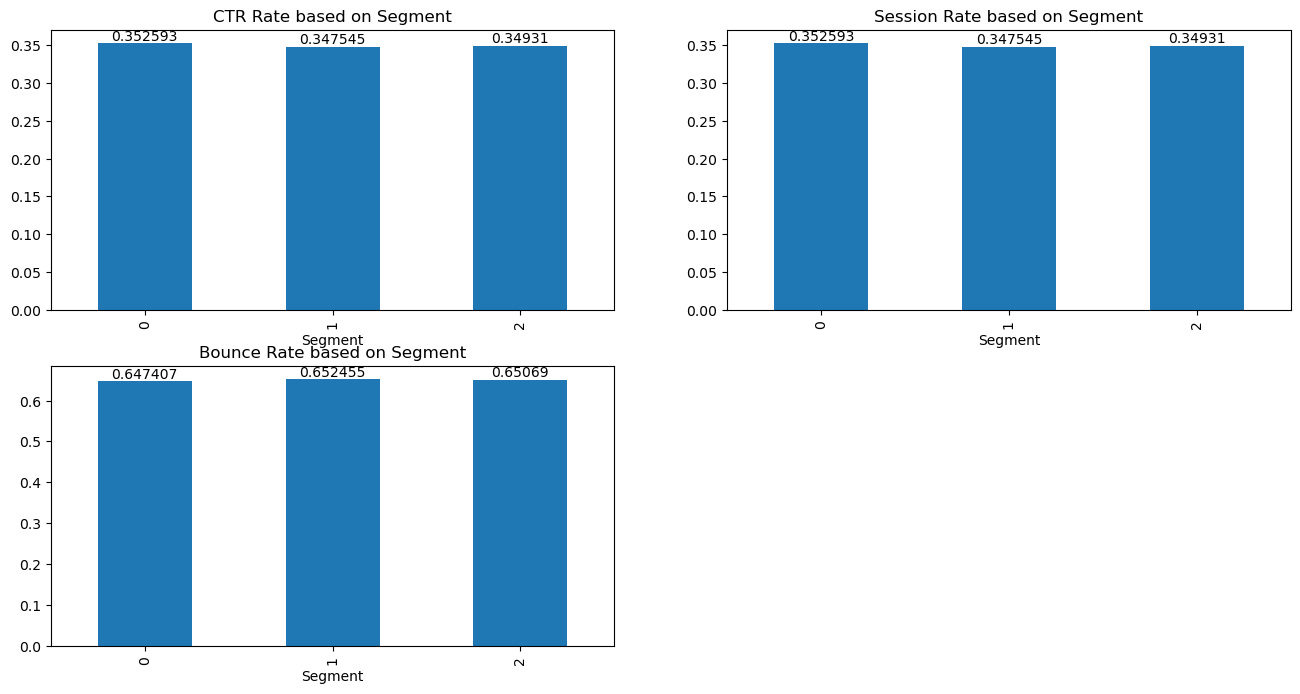

In [222]:
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
plt.title("CTR Rate based on Segment")
ax = df.groupby("Segment")["click"].mean().plot(kind="bar")
for container in ax.containers:
    ax.bar_label(container)

plt.subplot(2,2,2)
plt.title("Session Rate based on Segment")
ax =df.groupby("Segment")["click"].mean().plot(kind="bar")
for container in ax.containers:
    ax.bar_label(container)


plt.subplot(2,2,3)
plt.title("Bounce Rate based on Segment")
ax = df.groupby("Segment")["click"].apply(lambda x:(x==0).mean()).plot(kind="bar")
for container in ax.containers:
    ax.bar_label(container)



# Insights-: Segment and Segment Bias
1) Click Through Rate(CTR) is same across all Segemnts
2) Session Rate is same across all Segemnts as well.
3) Bounce Rate is same across all segemnts as well
4) The uniformity in CTR, session rate, and bounce rate across segments implies that the dataset is evenly distributed, with each segment containing a balanced mix of users from both the Control and Experimental groups. This supports the validity of the A/B test design and reduces the risk of segment bias.

# (C) - What is CTR(Click thorugh Rate) based on device_type,referral_source

<Axes: title={'center': 'CTR(Click thorugh Rate) based on referral_source'}, ylabel='click'>

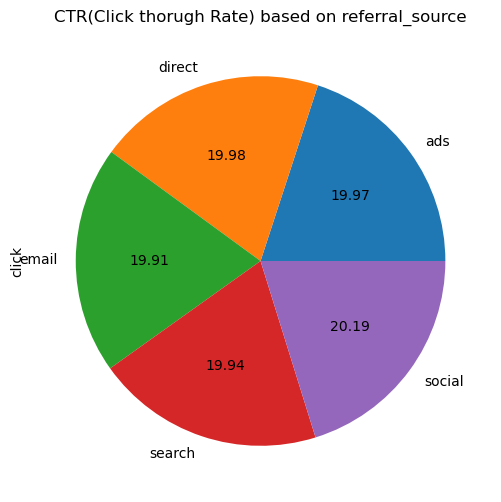

In [226]:
plt.figure(figsize=(14,6))
plt.title("CTR(Click thorugh Rate) based on referral_source")
df.groupby("referral_source")["click"].mean().plot(kind="pie",autopct="%0.2f")


<Axes: title={'center': 'CTR(Click thorugh Rate) based on device_type'}, ylabel='click'>

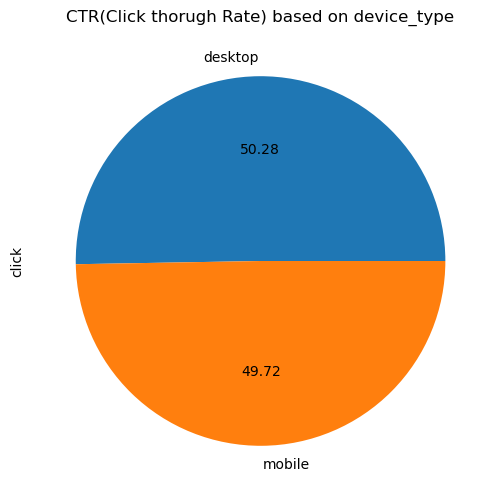

In [228]:
plt.figure(figsize=(14,6))
plt.title("CTR(Click thorugh Rate) based on device_type")
df.groupby("device_type")["click"].mean().plot(kind="pie",autopct="%0.2f")

# Insight on Device Type & Referral Source vs. Click-Through Rate (CTR):
Device type and referral source do not significantly impact the Click-Through Rate (CTR) — users coming from mobile or desktop, or arriving via email, ads, search, and other sources, all show similar CTRs.
This suggests that user engagement is more influenced by the design/interface of the webpage, how well it aligns with user needs, and its visual appeal, rather than the platform or source through which users access the application.



# (D) - What is CTR(Click thorugh Rate) of Experimental vs Controlled Group

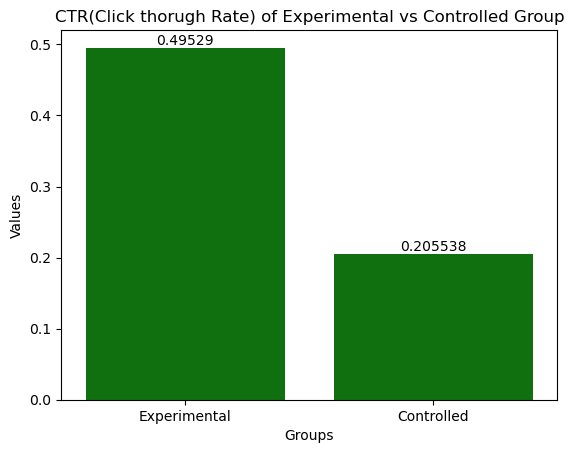

In [232]:
exp = len(df[(df["groups_exp"]=="exp") & (df["click"]==1)])/len(df[df["groups_exp"]=="exp"])
con= len(df[(df["groups_exp"]=="con") & (df["click"]==1)])/len(df[df["groups_exp"]=="con"])
df_n = pd.DataFrame({"Groups":["Experimental","Controlled"],"Values":[exp,con]})
ax =sns.barplot(x="Groups",y="Values",data=df_n,color="green")
plt.title("CTR(Click thorugh Rate) of Experimental vs Controlled Group")
for container in ax.containers:
    ax.bar_label(container)

# Insights-:
1) The Experimental group achieved a CTR of 0.49, which is more than double that of the Control group (0.20).
This clearly indicates that the changes made to the web application—whether in UI design, content, or functional logic—have had a positive impact on user engagement. 
It demonstrates that thoughtful modifications can substantially improve user interaction and conversion potential.

# (E) - What is Session Time of Experimental vs Controlled Group

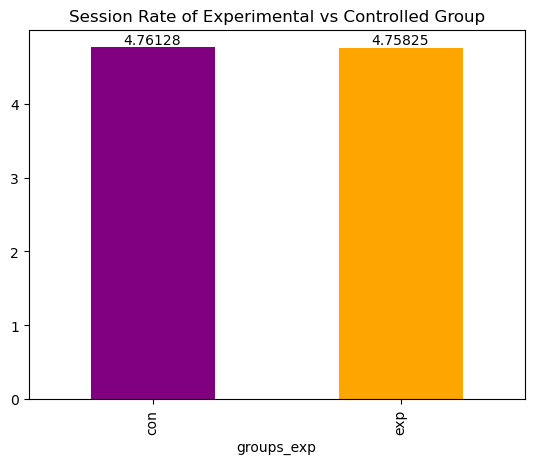

In [88]:
ax =df.groupby("groups_exp")["session_time"].mean().plot(kind="bar",color=["purple","orange"])
plt.title("Session Rate of Experimental vs Controlled Group")
for container in ax.containers:
    ax.bar_label(container)

# Insights-:
1) Although Controlled Group have better CTR,the average session time a user spends after making changed to web application is almost the same as before.This shows that user spending
same time even after changes but they clicking more which is possibly due to more interactive interface or more aligned content.

# (F) - What is Bounce Rate of Experimental vs Controlled Group

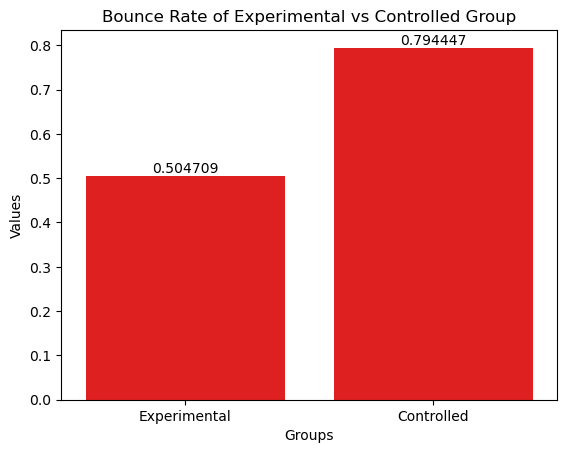

In [93]:
exp = len(df[(df["groups_exp"]=="exp") & (df["click"]==0)])/len(df[df["groups_exp"]=="exp"])
con= len(df[(df["groups_exp"]=="con") & (df["click"]==0)])/len(df[df["groups_exp"]=="con"])
df_n = pd.DataFrame({"Groups":["Experimental","Controlled"],"Values":[exp,con]})
ax =sns.barplot(x="Groups",y="Values",data=df_n,color="red")
plt.title("Bounce Rate of Experimental vs Controlled Group")
for container in ax.containers:
    ax.bar_label(container)

# Insights-:
1) Bounce Rate(Means rate of user leaving the service without even interacting with it) is more for Controlled Group which is almost 0.80,whereas experimental group have bounce rate of
0.50.This shows that half user return after watching the web service whereas half of users clicks and interact with web application which is good in term of reliability.

# 7 - A/B Testing(Hypothesis Testing)

# Metrics to Evaluate-:
1 - Coversion Rate or CTR(Click through Rate)

2 - Session Time

3 - Bounce Rate(BR)

# 1 -  A/B testing to test stastical difference in Conversion rate

# H0(Null Hypothesis) - There is No difference in Conversion rate of Experimental and Control Group
# H1(Alternative Hypothesis - There is a significant differnce in Conversion rate of Experimental and control Group

# (A) - Preparing Data

In [103]:
group1 = df[df["groups_exp"]=="con"]
group2 = df[df["groups_exp"]=="exp"]

# (B) - Using Z test Since Click is Categorical(0 or 1)

In [108]:
c1= group1["click"].sum()
c2 =group2["click"].sum()
s1 = len(group1)
s2 = len(group2)
count = np.array([c1,c2])
total = np.array([s1,s2])

from statsmodels.stats.proportion import proportions_ztest
z_stat,p_value = proportions_ztest(count,total)
if p_value<0.05:
     print("We reject null Hypothesis,There is Enough Evidece to say that there is significant differnce in click rate of Experimental and Control Group")
else:
    print("We Reject the null Hypothesis.There is not Enough Evidence to reject Null")

We reject null Hypothesis,There is Enough Evidece to say that there is significant differnce in click rate of Experimental and Control Group


# (C) - Checking Correctness

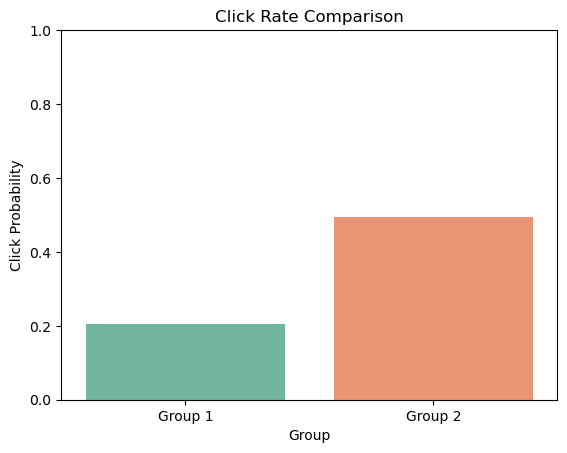

In [111]:
click_rates = pd.DataFrame({
    "Group": ["Group 1", "Group 2"],
    "Click Rate": [group1["click"].mean(), group2["click"].mean()]
})

sns.barplot(data=click_rates, x="Group", y="Click Rate", palette="Set2")
plt.title("Click Rate Comparison")
plt.ylim(0, 1)
plt.ylabel("Click Probability")
plt.show()


# 2 -  A/B testing to test stastical difference in Session time

# H0(Null Hypothesis) - There is No difference in Session time of Experimental and Control Group
# H1(Alternative Hypothesis - There is a significant differnce in Session time of Experimental and control Group

In [115]:
# (A)-Checking Distribution

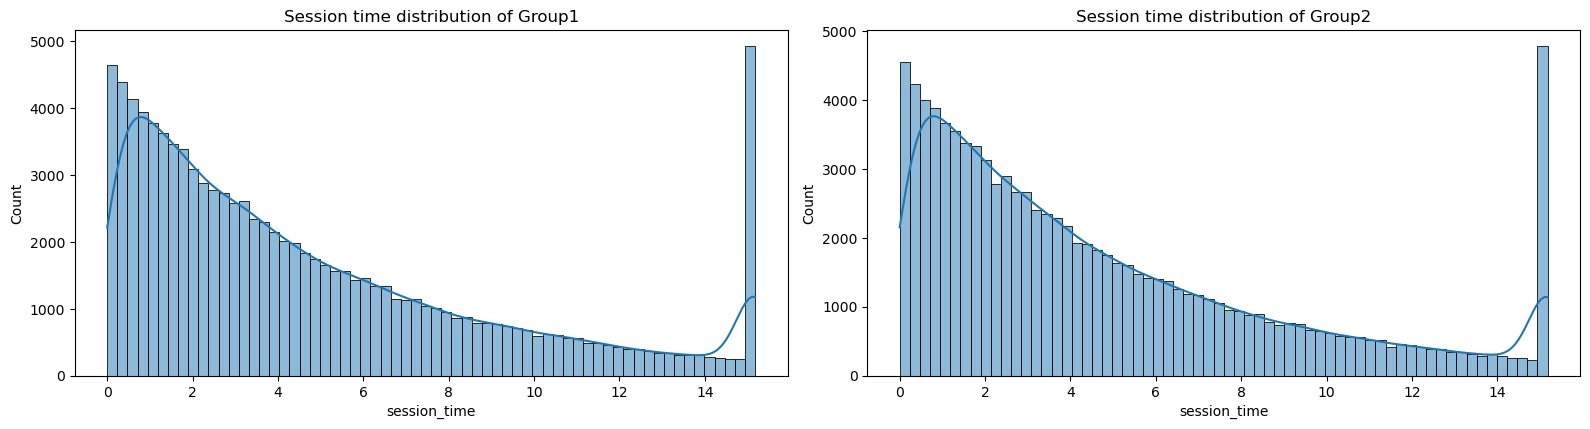

In [117]:
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
plt.title("Session time distribution of Group1")
sns.histplot(group1["session_time"],kde=True)   # Since it is skewed so possibility that it is not normally distributed
plt.subplot(2,2,2)
plt.title("Session time distribution of Group2")
sns.histplot(group2["session_time"],kde=True)
plt.tight_layout()
plt.show()

# (b)-Checking Normality using Shapiro Test

In [120]:
from scipy.stats import shapiro

In [122]:
stat,p_value = shapiro(group1["session_time"])
if p_value<0.05:
     print("data is normal")
else:
    print("data is not normal")

data is normal


In [124]:
stat,p_value = shapiro(group2["session_time"])
print(p_value)
if p_value<0.05:
     print("data is normal")
else:
    print("data is not normal")

8.469922431570191e-118
data is normal


In [130]:
from scipy.stats import ttest_ind
stat,p_value = ttest_ind(group1["session_time"],group2["session_time"],equal_var=False)
print(p_value)
if p_value<0.05:
     print("We reject null Hypothesis,There is Enough Evidece to say that there is significant differnce in Session time of Experimental and Control Group")
else:
    print("We Reject the null Hypothesis.There is not Enough Evidence to reject Null.Means Avg Session time is same for contolled and experimental group.")

0.8730505804141296
We Reject the null Hypothesis.There is not Enough Evidence to reject Null.Means Avg Session time is same for contolled and experimental group.


# (C) - Checking Correctness

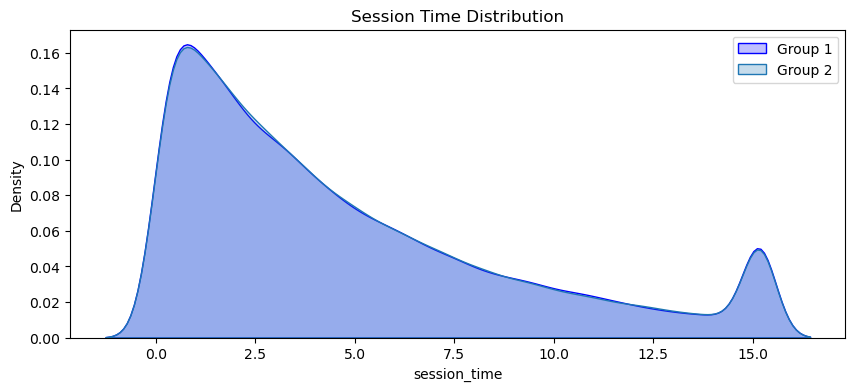

In [135]:
import seaborn as sns
plt.figure(figsize=(10,4))
sns.kdeplot(group1["session_time"], label="Group 1", fill=True,color="blue")
sns.kdeplot(group2["session_time"], label="Group 2", fill=True)
plt.legend()
plt.title("Session Time Distribution")
plt.show()


# Since the Avg session time almost same for experimental and controlled group in real data so we do not reject the null

# 3-  A/B testing to test stastical difference in Bounce rate

# H0(Null Hypothesis) - There is No difference in Bounce rate of Experimental and Control Group
# H1(Alternative Hypothesis - There is a significant differnce in Bounce rate of Experimental and control Group

# 1 - Using Z Test since Click is Categorical

In [141]:
counts1  = len(group1[group1["click"]==0])
counts2 =  len(group2[group2["click"]==0])
total1 = len(group1)
total2 =len(group2)
counts = np.array([counts1,counts2])
total = np.array([total1,total2])


In [143]:
from statsmodels.stats.proportion import proportions_ztest
z_stat,p_value = proportions_ztest(counts,total)
print(p_value)
if p_value<0.05:
     print("We reject null Hypothesis,There is Enough Evidece to say that there is significant differnce in Bounce rate of Experimental and Control Group")
else:
    print("We Reject the null Hypothesis.There is not Enough Evidence to reject Null")

0.0
We reject null Hypothesis,There is Enough Evidece to say that there is significant differnce in Bounce rate of Experimental and Control Group


# 2 - Checking Correctness

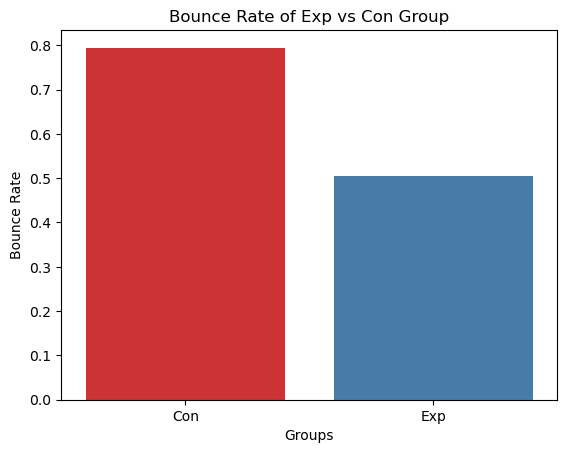

In [146]:
df_d = pd.DataFrame({
    'Groups': ["Con", "Exp"],
    'Bounce Rate': [
        (group1["click"] == 0).mean(),
        (group2["click"] == 0).mean()
    ]
})
sns.barplot(x ="Groups",y="Bounce Rate",data=df_d,palette="Set1")
plt.title("Bounce Rate of Exp vs Con Group")
plt.show()

# 8 -Calculate effect sizes using Cliff’s delta
Cliff Delta is used to calculate how much the statistical significant difference is there 

In [149]:
!pip install cliffs-delta

In [150]:
from cliffs_delta import cliffs_delta

delta,size = cliffs_delta(group2["click"].values,group1["click"].values)
print(delta,size)

0.2897372211823087 small


# positive mean user in group 2(experimental group) clicked more than group 1 (controlled group) This complements our Z-test or proportion test, which tells you if the difference is statistically significant.

# 9 - Exporting Data for Tableau Visualisation

In [21]:
df.drop("z_score",axis=1,inplace=True)
df.to_csv("Product_ETL.csv",index=False)